# Использование метода Монте-Карло для создания портфеля
> Using the Monte Carlo method to create a portfolio

- toc: true
- branch: master
- badges: true
- comments: true
- author: Zmey56
- categories: [finance, investment, python]

Начинающие (да и не только) инвесторы часто задаются вопросом о том, как отобрать для себя идеальное соотношение активов входящих в портфель. Часто (или не очень, но знаю про двух точно) у некоторых брокеров эту функцию выполняет торговый робот. Но заложенные в них алгоритмы не раскрываются.

В этом посте будет рассмотрено то, как оптимизировать портфель при помощи Python и симуляции Монте Карло. Под оптимизацией портфеля понимается такое соотношение весов, которое будет удовлетворять одному из условий:

* Портфель с минимальным уровнем риском при желаемой доходности;
* Портфель с максимальной доходностью при установленном риске;
* Портфель с максимальным значением доходности

Для расчета возьмем девять акций, которые рекомендовал торговый робот одного из брокеров на начало января 2020 года и так же он устанавливал по ним оптимальные веса в портфеле: 'ATVI','BA','CNP','CMA', 'STZ','GPN','MPC','NEM' и 'PKI'. Для анализа будет взяты данные по акциям за последние три года.

In [1]:
#Загружаем библиотеки

import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Получаем данные по акциям
ticker = ['ATVI','BA','CNP','CMA', 'STZ','GPN','MPC','NEM', 'PKI']

stock = yf.download(ticker,'2017-01-01', '2019-01-31') 

[*********************100%***********************]  9 of 9 completed


Если сложить долю всех акций, входящих в портфель, то сумма должна стремиться к единице (а лучше быть равна). Дальше как обычно проведем подготовку данных для расчетов:

In [2]:
# Выделение скорректированой цены закрытия
all_adj_close = stock[['Adj Close']]

# ежедневная доходность
all_returns = all_adj_close.pct_change()

# узнаем среднюю доходность и получаем ковариационную матрицу
mean_returns = all_returns.mean()
cov_matrix = all_returns.cov()

Теперь можно провести расчет для весов предложенных торговым роботом и узнать доходность данного портфеля за последник три года и стандартное отклонение.

In [3]:
#предложение по весам торгового робота
robot = np.array([0.0441, 0.1030, 0.1086, 0.2070, 0.1525, 0.0714, 0.0647, 0.1828, 0.0661])

# доходность, стандартное отклонение и коэффициент Шарпо
portfolio_return_robot = np.sum(mean_returns * robot)
portfolio_std_dev_robot = np.sqrt(np.dot(robot.T,np.dot(cov_matrix, robot)))
sharpo_robot = portfolio_return_robot/portfolio_std_dev_robot

# объединим полученные значения в таблицу и выведем ее 
robot_result = np.array([portfolio_return_robot, portfolio_std_dev_robot, sharpo_robot])
robot_result = np.array([portfolio_return_robot, portfolio_std_dev_robot, sharpo_robot])
robot_result = np.concatenate((robot_result, robot), axis=0)
robot_sim_result = pd.DataFrame(robot_result, columns=['Robot'], index=['ret','stdev','sharpe',ticker[0],ticker[1],ticker[2],ticker[3],ticker[4],ticker[5],ticker[6],ticker[7],ticker[8]])

print(robot_sim_result) 

           Robot
ret     0.000852
stdev   0.008635
sharpe  0.098683
ATVI    0.044100
BA      0.103000
CNP     0.108600
CMA     0.207000
STZ     0.152500
GPN     0.071400
MPC     0.064700
NEM     0.182800
PKI     0.066100


**Симуляция Монте-Карло**

Первоначально небольшое вступительное слово о том, как используется метод Монте-Карла для оптимизации портфеля

Сначала акциям задаются случайные веса, после чего производится расчет доходности и стандартного отклонения. Полученные значения сохраняются. Следующим шагом случайным образом меняются веса (главное не забывать, что их сумма должна составлять единицу) и все повторяется — расчет и сохранение полученного значения. Количество итераций зависит от времени, мощностей компьютера для расчета и рисков, который готов принять инвестор. В этот раз попробуем провести 10000 расчетов для выявления портфеля с минимальным убытком и максимальным значением коэффициента Шарпа.

In [4]:
#создаем массив из нулей
num_iterations = 10000
simulation_res = np.zeros((4+len(ticker)-1,num_iterations))

# сама итерация
for i in range(num_iterations):
        #Выбрать случайные веса и нормализовать, чтоб сумма равнялась 1
        weights = np.array(np.random.random(9))
        weights /= np.sum(weights)
        
        #Вычислить доходность и стандартное отклонение
        portfolio_return = np.sum(mean_returns * weights)
        portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights)))
        
        #Сохранить все полученные значения в массив
        simulation_res[0,i] = portfolio_return
        simulation_res[1,i] = portfolio_std_dev
        
        #Вычислить коэффициент Шарпа и сохранить
        simulation_res[2,i] = simulation_res[0,i] / simulation_res[1,i]
        
        #Сохранить веса
        for j in range(len(weights)):
                simulation_res[j+3,i] = weights[j]

# сохраняем полученный массив в DataFrame для построения данных и анализа.
sim_frame = pd.DataFrame(simulation_res.T,columns=['ret','stdev','sharpe',ticker[0],ticker[1],ticker[2],ticker[3],ticker[4],ticker[5],ticker[6],ticker[7],ticker[8]])

Теперь можно рассчитать портфель с максимальным коэффициентом Шарпа или минимальным риска.

In [5]:
# узнать максимальный Sharpe Ratio
max_sharpe = sim_frame.iloc[sim_frame['sharpe'].idxmax()]

# узнать минимальное стандартное отклонение
min_std = sim_frame.iloc[sim_frame['stdev'].idxmin()]

print ("The portfolio for max Sharpe Ratio:\n", max_sharpe)
print ("The portfolio for min risk:\n", min_std)

The portfolio for max Sharpe Ratio:
 ret       0.001258
stdev     0.010977
sharpe    0.114567
ATVI      0.065653
BA        0.377049
CNP       0.028034
CMA       0.102441
STZ       0.149974
GPN       0.091727
MPC       0.020134
NEM       0.155008
PKI       0.009980
Name: 9001, dtype: float64
The portfolio for min risk:
 ret       0.000546
stdev     0.007489
sharpe    0.072923
ATVI      0.020115
BA        0.021464
CNP       0.179417
CMA       0.256539
STZ       0.035221
GPN       0.100015
MPC       0.209400
NEM       0.076111
PKI       0.101716
Name: 9578, dtype: float64


Ну а самое важное представление можно получить, когда данные визуализируешь:

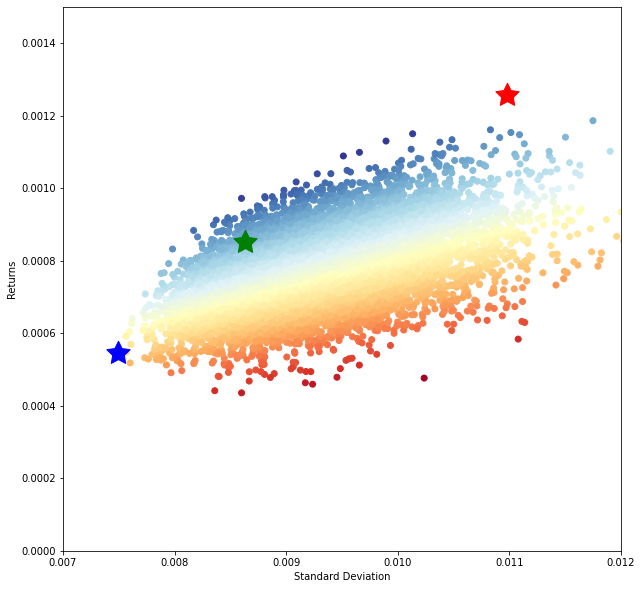

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))

#Создать разноцветный график  scatter plot для различных значений коэффициента Шарпо по оси x и стандартного отклонения по оси y

plt.scatter(sim_frame.stdev,sim_frame.ret,c=sim_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.ylim(0,.0015)
plt.xlim(0.007,0.012)

plt.scatter(max_sharpe[1],max_sharpe[0],marker=(5,1,0),color='r',s=600)

plt.scatter(min_std[1],min_std[0],marker=(5,1,0),color='b',s=600)

plt.scatter(portfolio_std_dev_robot, portfolio_return_robot,marker=(5,1,0),color='g',s=600)

plt.show()

Портфель с максимальным коэффициентом Шарпа показан красной звездой, синей — с минимальным стандартным отклонением и зеленой — предложенный роботом. Как видно — портфель, предложенный роботом, не совпадает с этими показателями, но на каком остановиться портфеле — выбор остается за инвестором. А я постараюсь в конце года вернуться к сравнению портфелей. А сейчас все три портфеля находятся в просадке.